#Analysis of the Results

##Preparation

In [ ]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import nltk
import numpy as np
import scipy.stats as stats
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader
from nltk.probability import FreqDist
from nltk.draw.dispersion import dispersion_plot
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from collections import Counter
import string
from wordcloud import WordCloud

In [ ]:
!unzip color.zip
!unzip palettes.zip
!unzip sheets.zip

##1 - Exploratory Data Analysis

We begin with simple data exploration and visualisations to get some insights.

In [ ]:
df = pd.read_excel("/content/video_data.xlsx")

In [ ]:
df

,Title,Year,Resolution,Format,Duration,fps,Frames,Shots,ASL,Spearman Correlation of Brightness and Movement,Filmed in
0,ACT UP Albany Action,1988,720p,mp4,11m 55s,24,17225,63,11.12,0.77,16mm
1,ACT UP Kiss-In,1988,720p,mp4,02m 59s,24,4331,4,36.02,0.34,16mm
2,Elegy in the Streets,1989,720p,mp4,27m 21s,24,39366,224,7.24,0.76,16mm
3,Gay and Lesbian Pride March 1985,1985,720p,mp4,17m 54s,24,25813,96,11.04,0.52,16mm
4,Gay and Lesbian Pride March and Gay Pride Run ...,1986,720p,mp4,08m 31s,18,9012,39,12.76,0.17,16mm
5,Gay Pride Run 1983,1983,720p,mp4,21m49s,18,23582,48,27.24,0.83,Super 8
6,Gay Pride Run 1985,1985,720p,mp4,09m 43s,24,14001,28,20.70,0.33,16mm
7,International March for Lesbian and Gay Freedom,1984,720p,mp4,11m 05s,24,15994,69,9.34,0.72,16mm
8,"June 12, 1982",1982,720p,mp4,08m 52s,18,9619,27,18.99,0.54,Super 8
9,Lesbian & Gay Pride New York 1983,1983,720p,mp4,11m 46s,18,12729,20,33.63,0.82,Super 8


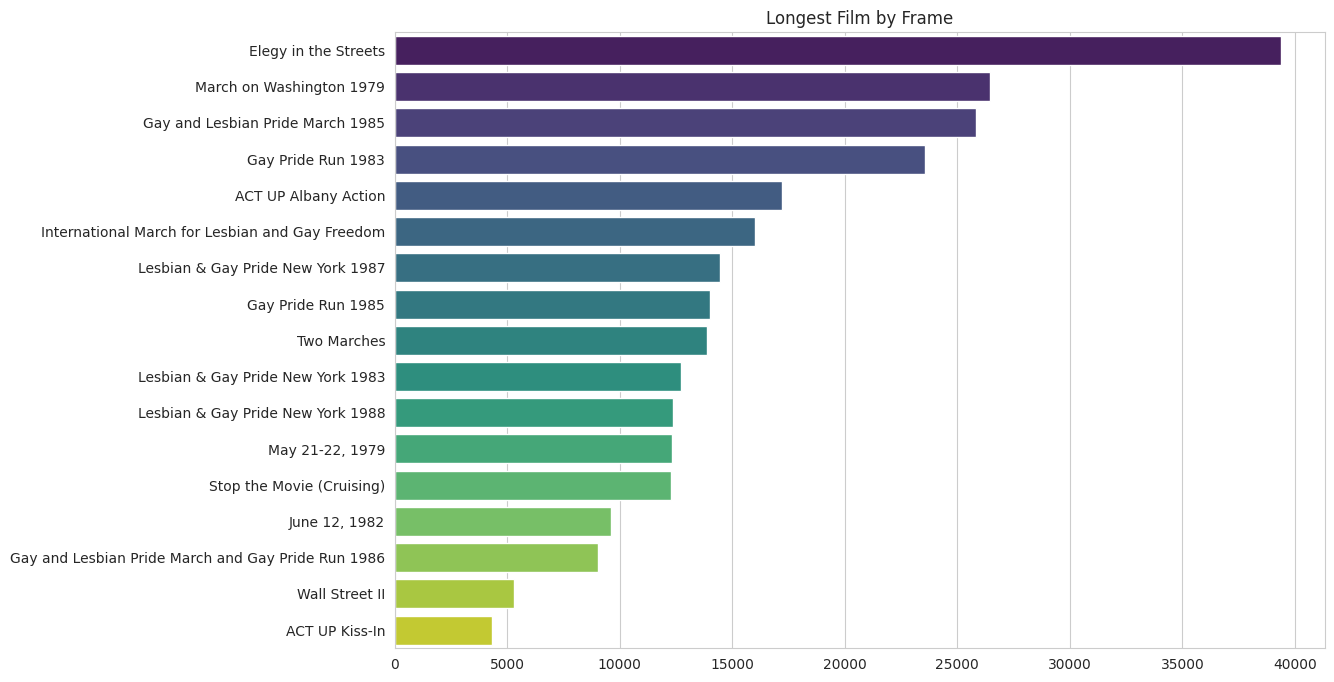

In [ ]:
df_sorted = df.sort_values(by='Frames', ascending=False)

sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.barplot(x='Frames', y='Title', data=df_sorted, hue='Title', palette='viridis', legend=False)
plt.title('Longest Film by Frame')
plt.xlabel('')
plt.ylabel('')
plt.show()

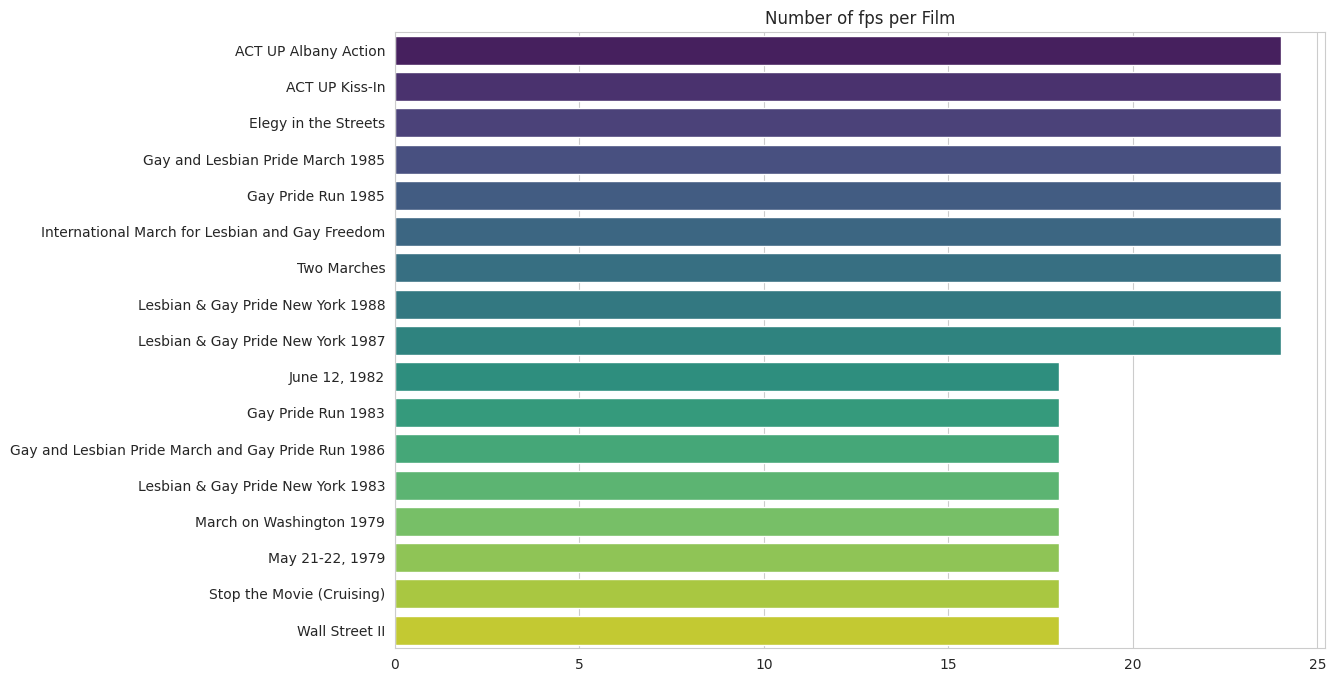

In [ ]:
df_sorted = df.sort_values(by='fps', ascending=False)

sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.barplot(x='fps', y='Title', data=df_sorted, hue='Title', palette='viridis', legend=False)
plt.title('Number of fps per Film')
plt.xlabel('')
plt.ylabel('')
plt.show()

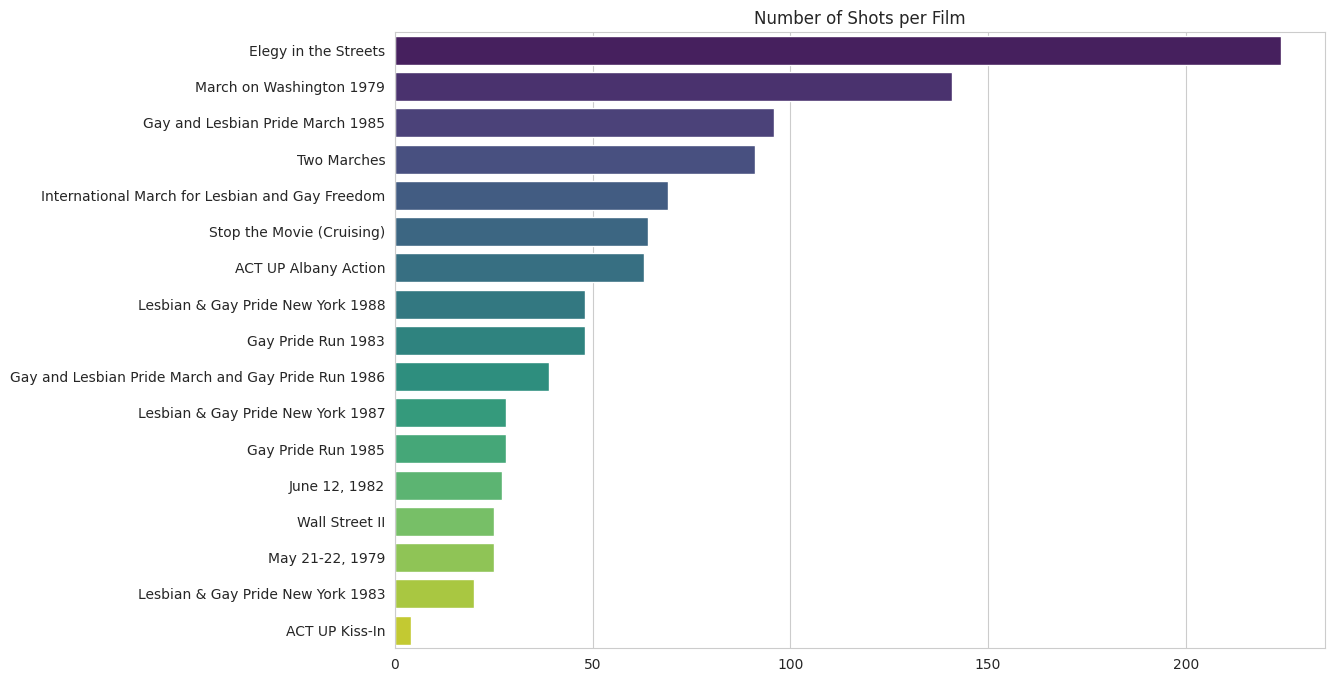

In [ ]:
df_sorted = df.sort_values(by='Shots', ascending=False)

sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.barplot(x='Shots', y='Title', data=df_sorted, hue='Title', palette='viridis', legend=False)
plt.title('Number of Shots per Film')
plt.xlabel('')
plt.ylabel('')
plt.show()

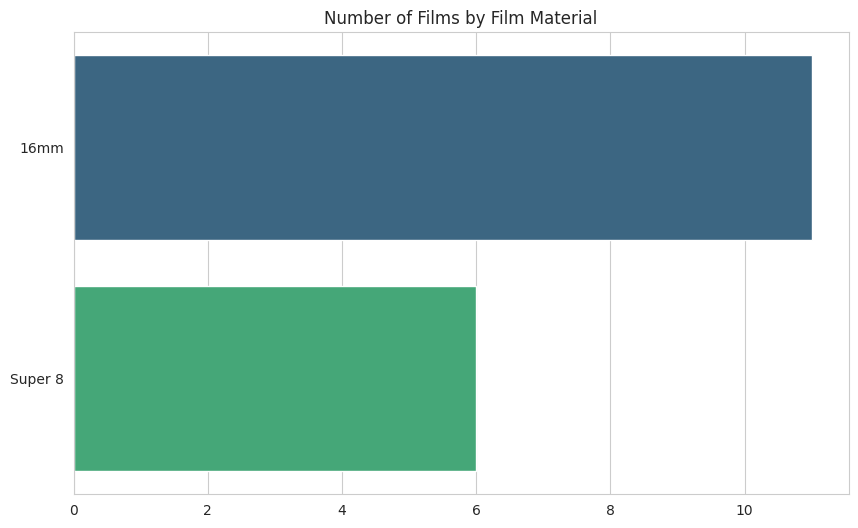

In [ ]:
film_counts = df['Filmed in'].value_counts().reset_index()
film_counts.columns = ['Filmed in', 'Count']

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Filmed in', data=film_counts, hue='Filmed in', palette='viridis', legend=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Films by Film Material')
plt.show()

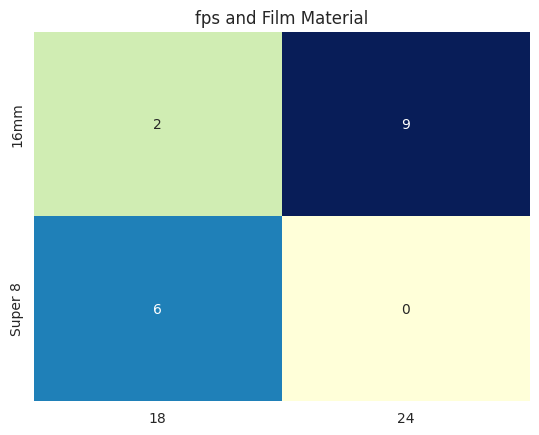

In [ ]:
fps_material_counts = df.groupby(['Filmed in', 'fps']).size().unstack(fill_value=0)
sns.heatmap(fps_material_counts, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('fps and Film Material')
plt.xlabel('')
plt.ylabel('')
plt.show()

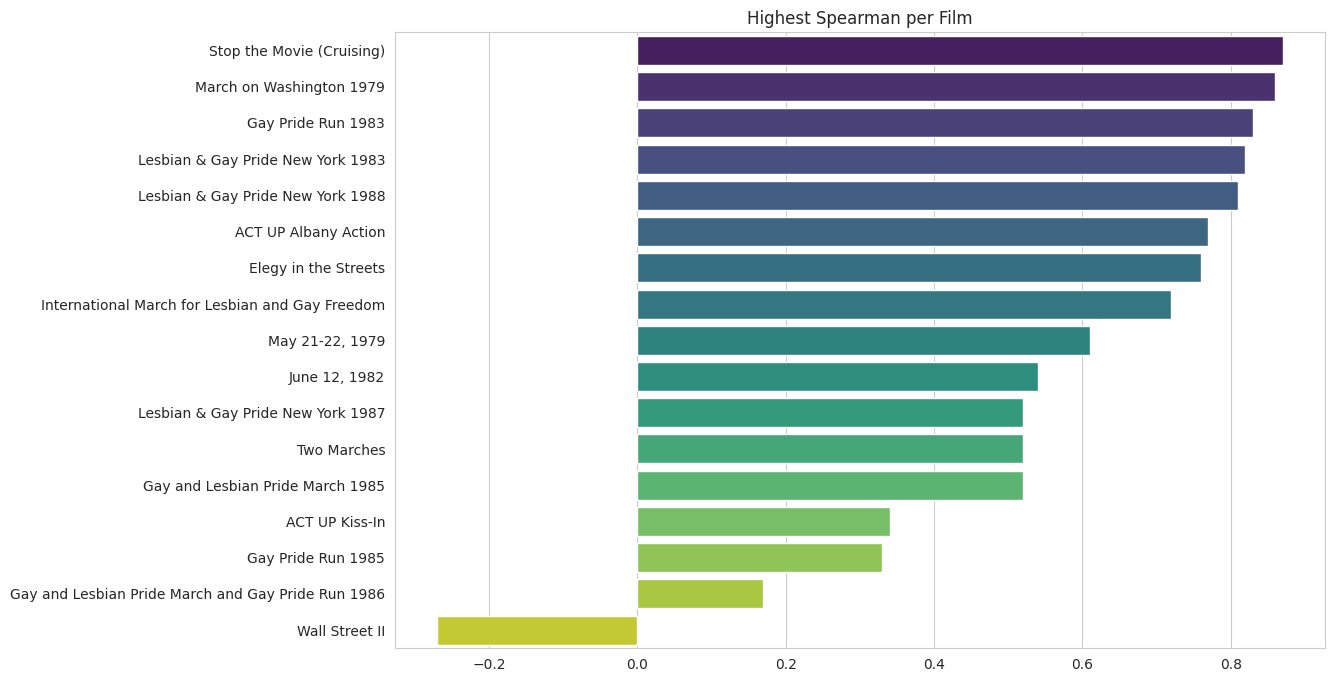

In [ ]:
df_sorted = df.sort_values(by='Spearman Correlation of Brightness and Movement', ascending=False)

sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.barplot(x='Spearman Correlation of Brightness and Movement', y='Title', data=df_sorted, hue='Title', palette='viridis', legend=False)
plt.title('Highest Spearman per Film')
plt.xlabel('')
plt.ylabel('')
plt.show()

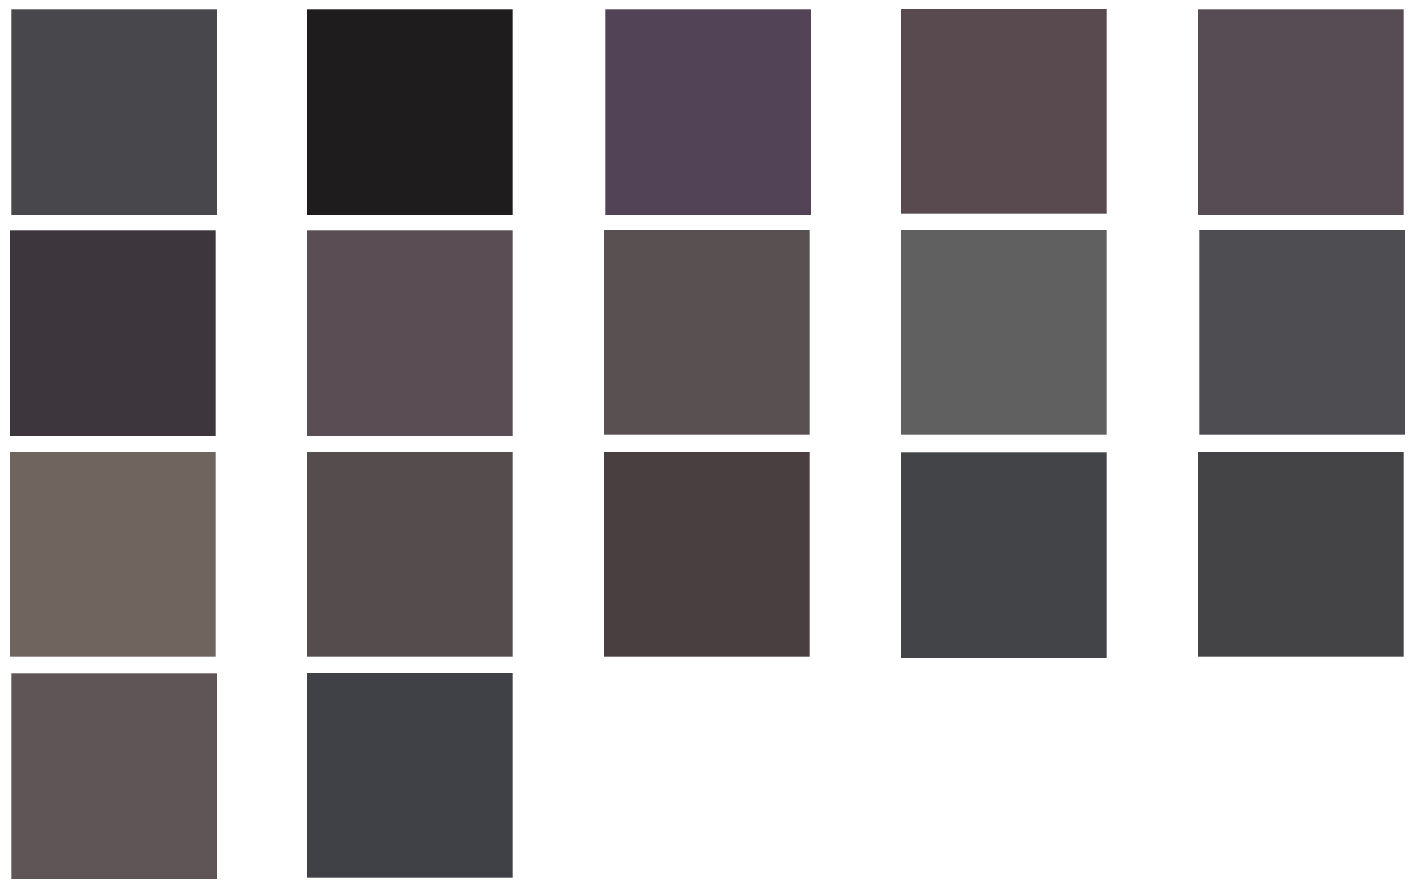

In [ ]:
image_folder = '/content/color'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()

cols = 5
rows = 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
axes = axes.flatten()

for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(image_folder, image_file))
    axes[i].imshow(img)
    axes[i].axis('off')

for j in range(len(image_files), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

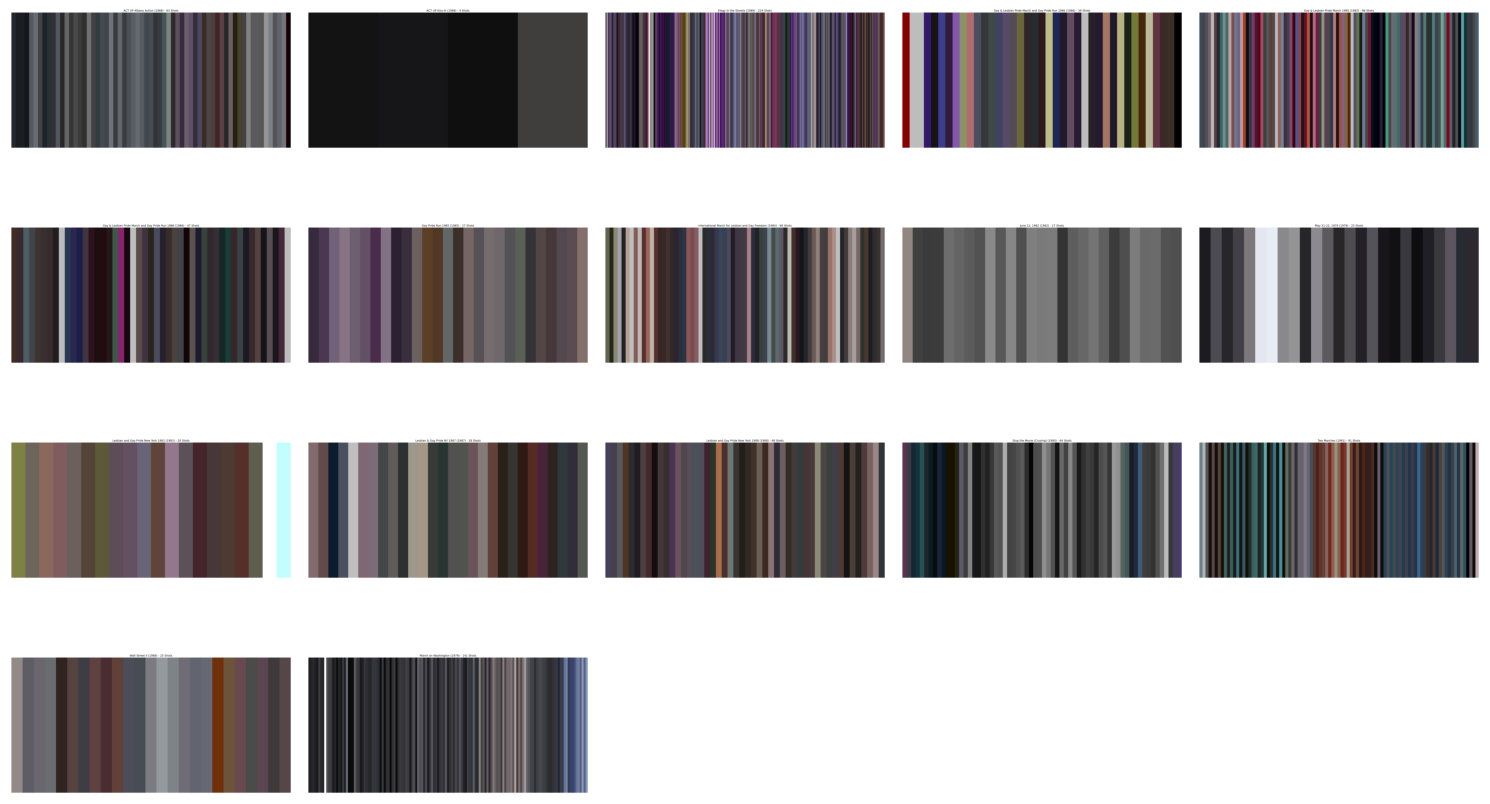

In [ ]:
image_folder = '/content/palettes'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()

cols = 5
rows = 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
axes = axes.flatten()

for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(image_folder, image_file))
    axes[i].imshow(img)
    axes[i].axis('off')

for j in range(len(image_files), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 2 - Statistical Analysis

We now conduct some statistical analysis on the results, first by looking at the overall shot variation distribution

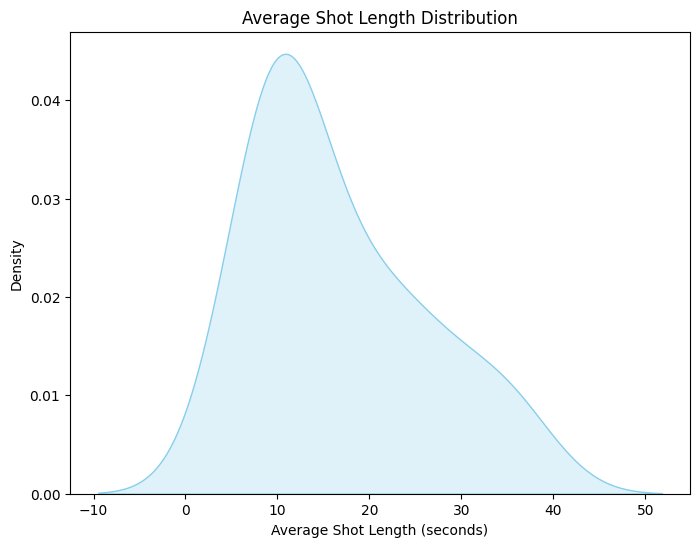

In [ ]:
df = pd.read_csv('/content/ASL_all.csv', delimiter=';')

plt.figure(figsize=(8, 6))
sns.kdeplot(x=df['ASL'], fill=True, color='skyblue')
plt.title('Average Shot Length Distribution')
plt.xlabel('Average Shot Length (seconds)')
plt.show()

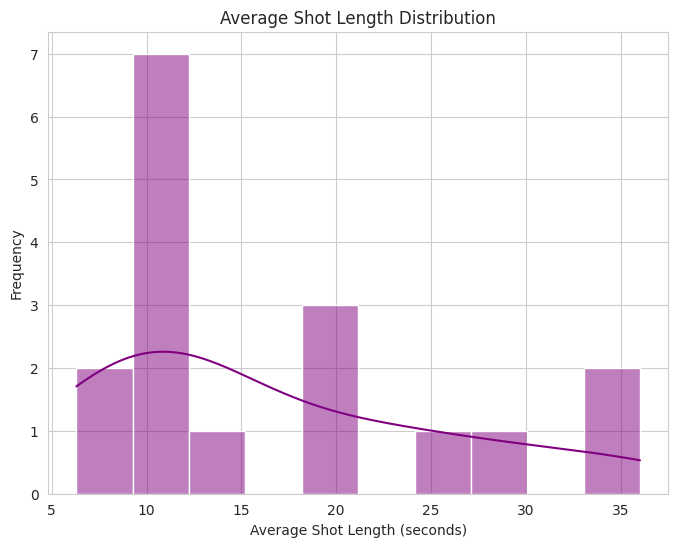

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['ASL'], kde=True, color='purple', bins=10)
plt.title('Average Shot Length Distribution')
plt.xlabel('Average Shot Length (seconds)')
plt.ylabel('Frequency')
plt.show()

Then we look at the Coefficient of Variation to identify each movie ASL directly

In [ ]:
df['CV'] = df['Std_Dev'] / df['ASL']
print(df[['Film', 'ASL', 'Std_Dev', 'CV']])

                                                 Film    ASL  Std_Dev  \
0                                ACT UP Albany Action  11.12    11.72   
1                                      ACT UP Kiss-In  36.02    56.36   
2                                Elegy in the Streets   7.24     8.29   
3                    Gay and Lesbian Pride March 1985  11.04    10.83   
4   Gay and Lesbian Pride March and Gay Pride Run ...  12.76    15.88   
5                                  Gay Pride Run 1983  27.24    32.12   
6                                  Gay Pride Run 1985  20.70    25.31   
7   International March for Lesbian and Gay Freedo...   9.34    13.81   
8                                    June Twelve 1982  18.99    18.80   
9                 Lesbian and Gay Pride New York 1983  33.63    32.88   
10                Lesbian and Gay Pride New York 1987  20.72    26.56   
11                Lesbian and Gay Pride New York 1988  10.69     9.47   
12                               March on Washingto

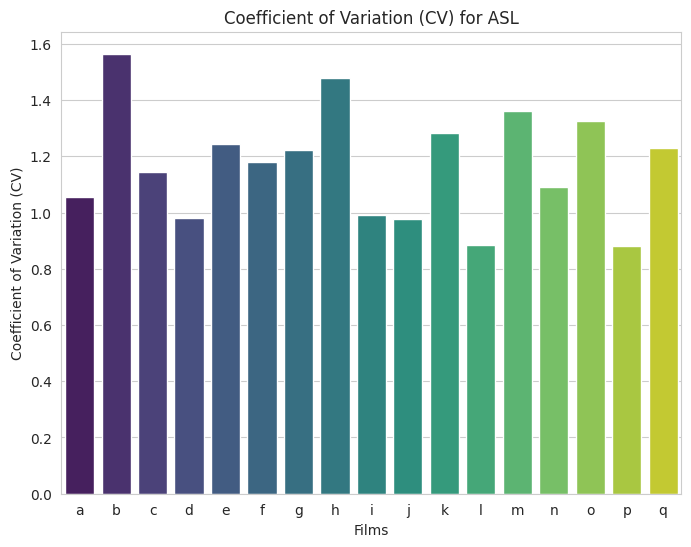

   Alias                                               Film
0      a                               ACT UP Albany Action
1      b                                     ACT UP Kiss-In
2      c                               Elegy in the Streets
3      d                   Gay and Lesbian Pride March 1985
4      e  Gay and Lesbian Pride March and Gay Pride Run ...
5      f                                 Gay Pride Run 1983
6      g                                 Gay Pride Run 1985
7      h  International March for Lesbian and Gay Freedo...
8      i                                   June Twelve 1982
9      j                Lesbian and Gay Pride New York 1983
10     k                Lesbian and Gay Pride New York 1987
11     l                Lesbian and Gay Pride New York 1988
12     m                               March on Washington 
13     n                                     May 21-22 1979
14     o                          Stop the Movie (Cruising)
15     p                                

In [ ]:
df['Alias'] = [chr(97 + i) for i in range(len(df))]  # 'a', 'b', 'c', etc.

plt.figure(figsize=(8, 6))
sns.barplot(x='Alias', y='CV', data=df, hue='Alias', palette='viridis', legend=False)
plt.title('Coefficient of Variation (CV) for ASL')
plt.ylabel('Coefficient of Variation (CV)')
plt.xlabel('Films')
plt.show()

print(df[['Alias', 'Film']])

Now we apply some descriptive statistics to the results of Spearman's correlation of brightness and movement.

In [ ]:
df = pd.read_excel('/content/video_data.xlsx')

#Descriptive Statistics
def analyze_spearman_correlation(series):
    return {
        'Count': len(series),
        'Mean': series.mean(),
        'Median': series.median(),
        'Standard Deviation': series.std(),
        'Variance': series.var(),
        'Minimum': series.min(),
        'Maximum': series.max(),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis()
    }

#Hypothesis Testing
def test_correlation_significance(series):
    t_statistic, p_value = stats.ttest_1samp(series, popmean=0)
    return {
        't-statistic': t_statistic,
        'p-value': p_value,
        'Significant at 0.05 level': p_value < 0.05
    }

spearman_column = df['Spearman Correlation of Brightness and Movement']


print("1. Descriptive Statistics:")
print(pd.Series(analyze_spearman_correlation(spearman_column)))

print("\n2. Hypothesis Testing:")
print(pd.Series(test_correlation_significance(spearman_column)))


#correlation strength
def interpret_spearman_correlation(value):
    if abs(value) < 0.2:
        return "Very weak correlation"
    elif abs(value) < 0.4:
        return "Weak correlation"
    elif abs(value) < 0.6:
        return "Moderate correlation"
    elif abs(value) < 0.8:
        return "Strong correlation"
    else:
        return "Very strong correlation"

print("\n4. Correlation Strength Interpretations:")
for val in spearman_column:
    print(f"Correlation {val:.2f}: {interpret_spearman_correlation(val)}")



1. Descriptive Statistics:
Count                 17.000000
Mean                   0.571765
Median                 0.610000
Standard Deviation     0.300671
Variance               0.090403
Minimum               -0.270000
Maximum                0.870000
Skewness              -1.495919
Kurtosis               2.627844
dtype: float64

2. Hypothesis Testing:
t-statistic                  7.840622
p-value                      0.000001
Significant at 0.05 level        True
dtype: object

4. Correlation Strength Interpretations:
Correlation 0.77: Strong correlation
Correlation 0.34: Weak correlation
Correlation 0.76: Strong correlation
Correlation 0.52: Moderate correlation
Correlation 0.17: Very weak correlation
Correlation 0.83: Very strong correlation
Correlation 0.33: Weak correlation
Correlation 0.72: Strong correlation
Correlation 0.54: Moderate correlation
Correlation 0.82: Very strong correlation
Correlation 0.52: Moderate correlation
Correlation 0.81: Very strong correlation
Correlation 

Then we visualize the correlations

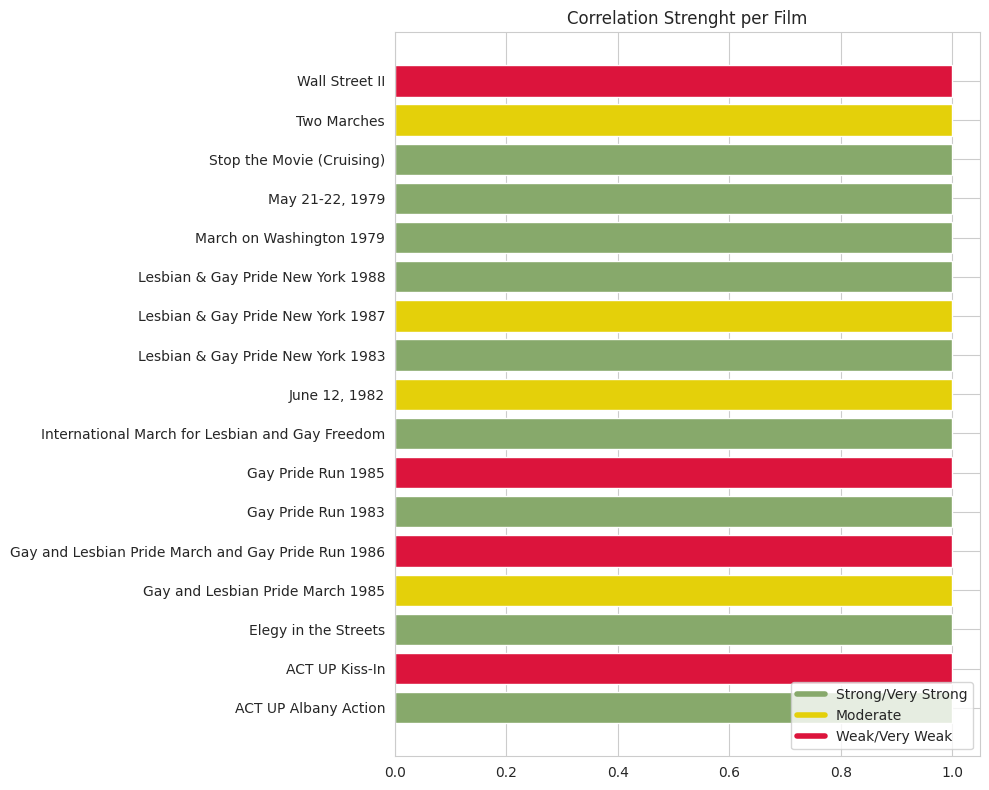

In [ ]:
df['correlation_interpretation'] = df['Spearman Correlation of Brightness and Movement'].apply(interpret_spearman_correlation)

def get_color(interpretation):
    if interpretation in ["Very strong correlation", "Strong correlation"]:
        return '#87A96B'
    elif interpretation == "Moderate correlation":
        return '#E4D00A'
    else:
        return '#DC143C'

df['color'] = df['correlation_interpretation'].apply(get_color)

plt.figure(figsize=(10, 8))
plt.barh(df['Title'], [1] * len(df), color=df['color'])
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation Strenght per Film')
plt.legend(handles=[
    plt.Line2D([0], [0], color='#87A96B', lw=4, label='Strong/Very Strong'),
    plt.Line2D([0], [0], color='#E4D00A', lw=4, label='Moderate'),
    plt.Line2D([0], [0], color='#DC143C', lw=4, label='Weak/Very Weak')],
    loc='lower right')
plt.tight_layout()
plt.show()

## 3 - Textual Analysis

To start with the textual analysis we first need to put all the description together in one dataframe

In [ ]:
folder_path = '/content/sheets'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]
df = pd.concat(dataframes, axis=0, ignore_index=True)

print(df)

               shot   shot_type  \
0     shot_0015.jpg      detail   
1     shot_0001.jpg   ambiguous   
2     shot_0009.jpg    longShot   
3     shot_0006.jpg   ambiguous   
4     shot_0023.jpg   ambiguous   
...             ...         ...   
1033  shot_0090.jpg   ambiguous   
1034  shot_0055.jpg  mediumShot   
1035  shot_0082.jpg   ambiguous   
1036  shot_0105.jpg     closeUp   
1037  shot_0003.jpg    longShot   

                                            description  
0     A group of people march down a street, carryin...  
1     Grainy footage shows a person holding a sign t...  
2     A group of people hold signs and protest outdo...  
3     A white surface with small, dark speckles is v...  
4     The image appears to be a white background wit...  
...                                                 ...  
1033  A blurry, grainy, black-and-white image appear...  
1034  A blurry, black and white image shows a person...  
1035  A blurry image shows a person wearing a light-...  

Now that all the description are together we can firstly visualize the most frequent shot type.

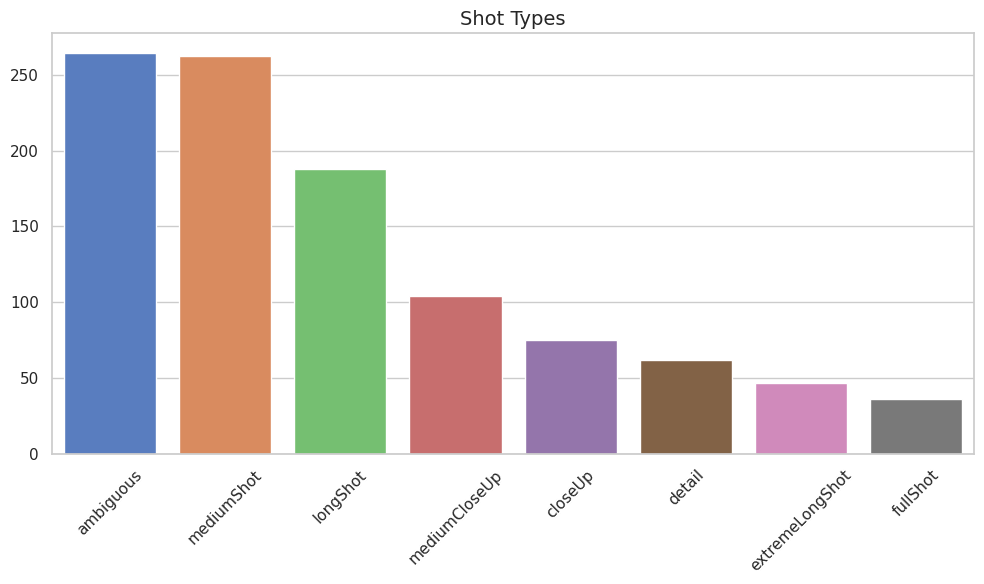

In [ ]:
counts = df['shot_type'].value_counts()

sns.set(style='whitegrid')

palette = sns.color_palette('muted', len(counts))


plt.figure(figsize=(10, 6))
ax = sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette=palette, legend=False)

ax.set_xlabel('', fontsize=12)
ax.set_ylabel('',)
ax.set_title('Shot Types', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now we start the textual analysis first by getting rid of the stopwords and the punctuation.

In [ ]:
nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text_spacy(text):
    doc = nlp(text.lower())
    tokens = [token.text for token in doc
              if token.text not in stop_words and not token.is_stop
              and not token.is_punct and token.is_alpha and len(token.text) > 1]
    return tokens

df['tokenized_description'] = df['description'].apply(clean_text_spacy)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Then we visualize the most frequent word in a wordcloud.
Words like "image", "shows" and "picture" were excluded since they appear in almost each one of the description because of the way the model described the shots. A frequent way the description starts is: "This image/picture shows...".

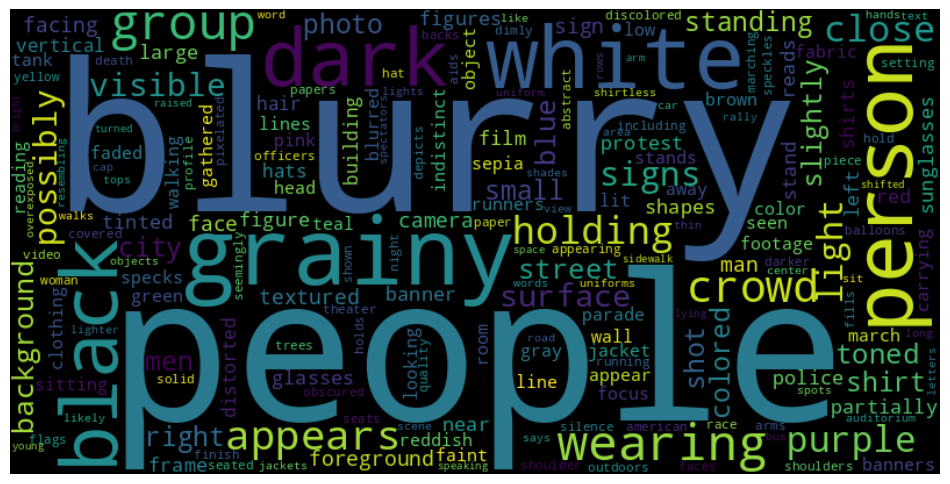

In [ ]:
all_tokens = [token for sublist in df['tokenized_description'] for token in sublist]
all_tokens = [word for word in all_tokens if word not in ['image', 'shows', 'picture']] #words to not include
word_freq = Counter(all_tokens)
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

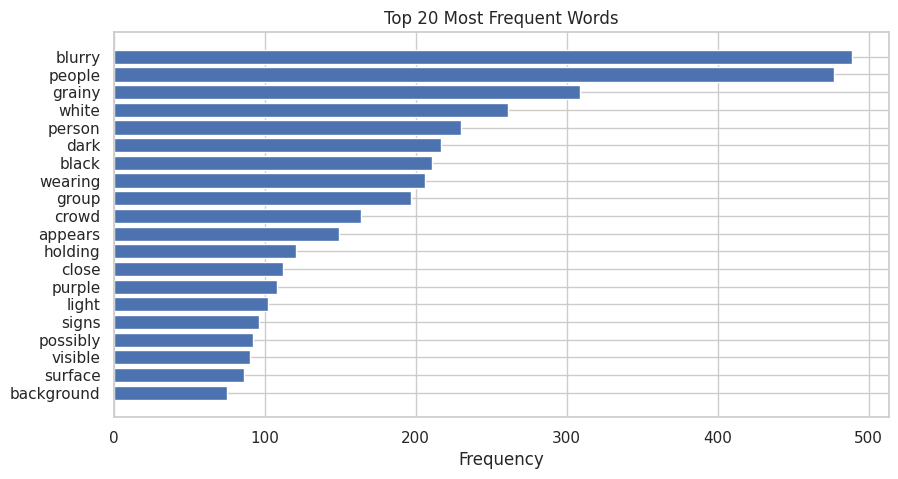

In [ ]:
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 5))
plt.barh(words, counts)
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.gca().invert_yaxis()
plt.show()

Now we do the same thing for the analysis of the protest signs. We firstly indentify all of the all caps words and then we look at the frequency with a word cloud.

In [ ]:
def extract_all_caps(text):
    all_caps_words = re.findall(r'\b[A-Z]+\b', text)
    return all_caps_words

def extract_all_caps_first_word(text):
    words = text.split()

    if words[0].isupper():
        words = words[1:]  #removing the first word from description, which is always capitalized

    all_caps_words = [word for word in words if word.isupper()]
    return all_caps_words

df['all_caps_words'] = df['description'].apply(extract_all_caps_first_word)

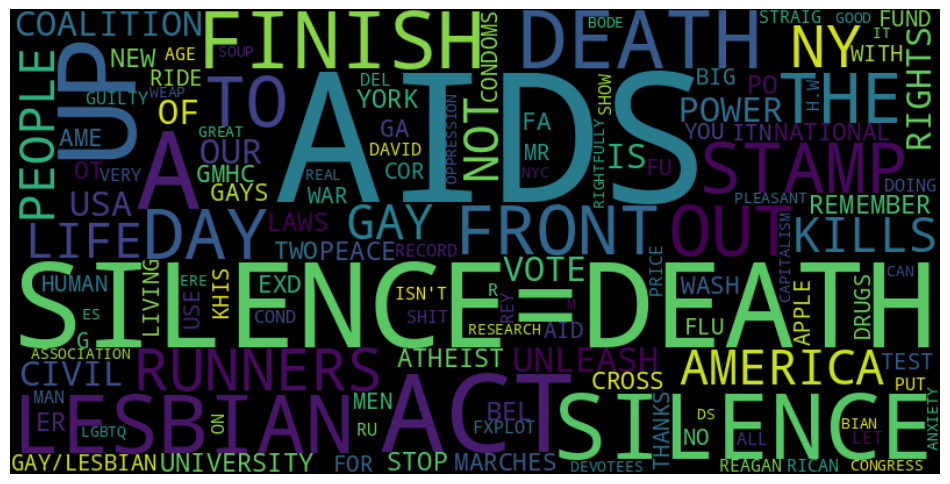

In [ ]:
all_caps_flat = [
    word.strip(string.punctuation)
    for sublist in df['all_caps_words']
    for word in sublist
    if word.strip(string.punctuation)
]

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(dict(Counter(all_caps_flat)))

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

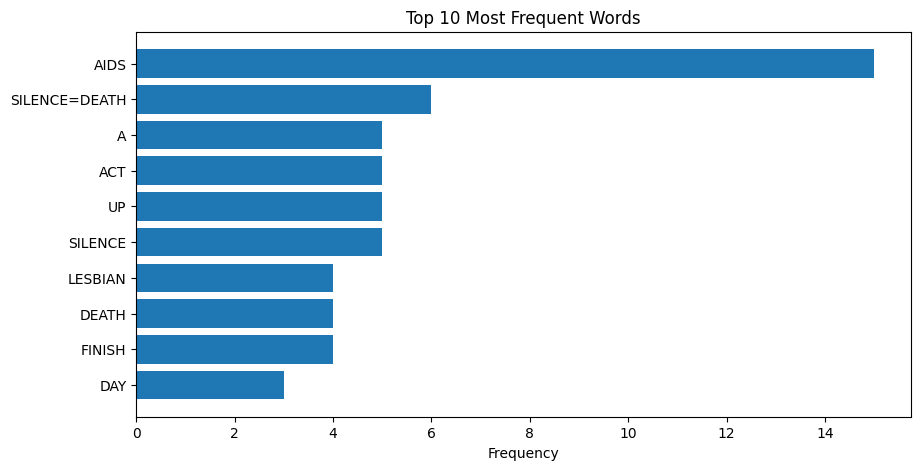

In [ ]:
word_counts = Counter(all_caps_flat)
common_words = word_counts.most_common(10)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 5))
plt.barh(words, counts)
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Words')
plt.gca().invert_yaxis()
plt.show()